### This my implementation for Covid-19 CT-Scan image Classification which was an assignment in Sharif University of Technology (mostly copied from the mentioned codes in blocks)

In [1]:
%matplotlib inline

**Project description:**

In this project, we want to create a Covid-19 binary classifier that predicts whether a patient is suffering from Coronavirus or not, using chest CT scans of patients.


please put your final best 
weights in a drive and share its public path with us in jupyter notebook.

we will give to top three models 20 point. 

**1- Import all the libraries you may need here:**

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import shutil


#Add Additional libraries here
import cv2
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models
import time
import copy

random.seed(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

Clone dataset and read images

In [3]:
# !git clone https://github.com/UCSD-AI4H/COVID-CT
# !unzip COVID-CT/Images-processed/CT_COVID.zip
# !unzip COVID-CT/Images-processed/CT_NonCOVID.zip
covid_files_path = 'CT_COVID/'
covid_files      = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
non_covid_files_path = 'CT_NonCOVID/'
non_covid_files      = [os.path.join(non_covid_files_path, x) for x in os.listdir(non_covid_files_path)]

In this dataset, We have the positive class with the scans of COVID-19 positive patients, whereas the negative class contains a mixture of healthy patients, and patients suffering from other (non-COVID-19) diseases that may cause opacities in the lungs.

Therefore, a practical classifier would have to differentiate between, say, COVID-19 induced pneumonia and other types of pneumonia.

**2- Show 3 random samples from NonCovid cases and 3 more from Covid cases CT-scans:**(5% point)

*hint: you can use "cv2" library for reading images*

*hint: All samples are stored in the variables "covid_files" and "non_covid_files".*

3 covid files


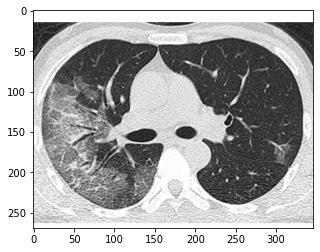

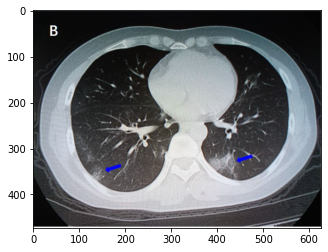

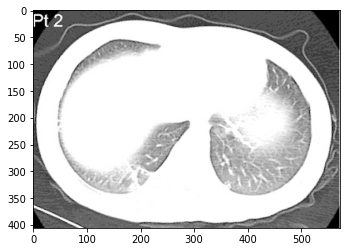

3 non covid files


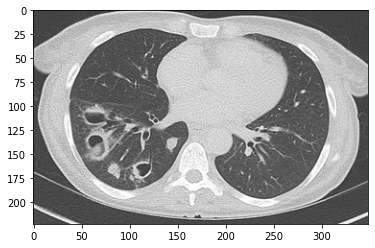

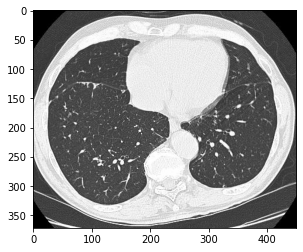

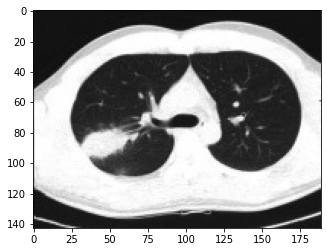

In [4]:
#CODE HERE
print("3 covid files")
cnt = 0
for i in covid_files:
    if cnt == 3:
        break
    img = cv2.imread(i)
    plt.imshow(img)
    plt.show()
    cnt += 1
    
print("3 non covid files")
cnt = 0
for i in non_covid_files:
    if cnt == 3:
        break
    img = cv2.imread(i)
    plt.imshow(img)
    plt.show()
    cnt += 1

The dataset is divided into three splits: the train set (425 examples), validation set (118 examples), and the test set (203 examples). Information for this split has been provided in the folder Data-split folder.  This folder contains text files which explain what files belong to each split.

We write a function to read these files and put them into a list of strings:

In [5]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

We then create the COVIDCTDataset class which basically subclasses the torch.utils.data.Dataset class:

In [6]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, classes, covid_files, non_covid_files, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.files_path = [non_covid_files, covid_files]
        self.image_list = []

        # read the files from data split text files
        covid_files = read_txt(covid_files)
        non_covid_files = read_txt(non_covid_files)

        # combine the positive and negative files into a cummulative files list
        for cls_index in range(len(self.classes)):
            
            class_files = [[os.path.join(self.root_dir, self.classes[cls_index], x), cls_index] \
                            for x in read_txt(self.files_path[cls_index])]
            self.image_list += class_files
                
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        path = self.image_list[idx][0]
        
        # Read the image
        image = Image.open(path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = int(self.image_list[idx][1])

        data = {'img':   image,
                'label': label,
                'paths' : path}

        return data

**3- Now you must declare preprocessing transformers for training and testing data(same for validation data)**(20% point)

**NOTE:** *don't change "train_transformer" and "val_transformer" variable names.*

For the training data:

1- Resize the shorter side of the image to 256 while maintaining the aspect ratio.

2- Do a random crop of size ranging from 50% to 100% of the dimensions of the image, and aspect ratio ranging randomly from 75% to 133% of the original aspect ratio. Finally, the crop is resized to 224 × 224.

3- Horizontally flip the image with a probability of 0.5.

4- Convert it to Tensor.

5- Normalize the image to have 0 mean and standard deviation of 1

In [7]:
#CODE HERE
train_transformer = transforms.Compose([
    transforms.Resize(size=256),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.75, 1.33)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    torchvision.transforms.Normalize((0,), (1,)),
])

For testing:

1- Resize the image to 224 × 224.

2- Convert in to Tensor.

3- Normalize the image to have mean 0 and standard deviation of 1

In [8]:
#CODE HERE
val_transformer = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    torchvision.transforms.Normalize((0,), (1,)),
])

With our Dataset and DataLoader classes defined, let us now instantiate them. We use the label 0 for the non-COVID cases, whereas we use 1 for the COVID positive cases.

In [9]:
batchsize = 8

trainset = CovidCTDataset(root_dir='COVID-CT/Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='COVID-CT/Data-split/COVID/trainCT_COVID.txt',
                          non_covid_files='COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                          transform= train_transformer)
valset = CovidCTDataset(root_dir='COVID-CT/Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='COVID-CT/Data-split/COVID/valCT_COVID.txt',
                          non_covid_files = 'COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir='COVID-CT/Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='COVID-CT/Data-split/COVID/testCT_COVID.txt',
                          non_covid_files='COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

**4- Now declare a function for calculating these metrics for every training epoch:**(15% point)

**Accuracy,Sensitivity,Specificity,Area under ROC,Confusion Matrix, and Validation Loss**

In [10]:
#CODE HERE
def ASSACV(prediction, real):
    # input_numpy = input.cpu().detach().numpy()
    # output_numpy = output.cpu().detach().numpy()
    # input_numpy, output_numpy = input, output
    tp = ((prediction == 1) & (real == 1)).sum()
    tn = ((prediction == 0) & (real == 0)).sum()
    fn = ((prediction == 0) & (real == 1)).sum()
    fp = ((prediction == 1) & (real == 0)).sum()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / tp + fn
    specifity = tn / tn + fp
    area_under_roc = roc_auc_score(real, prediction)
    conf_matrix = confusion_matrix(real, prediction)
    return accuracy, sensitivity, specifity, area_under_roc, conf_matrix

**5-We now define our model. Use your preferred pretrained model(VGG19,ResNet,DenseNet etc.)**(20% point)

In [11]:
cudnn.benchmark = True
plt.ion()   # interactive mode
#CODE HERE
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

We then replace its final linear layer with one having 2 neurons at its output, and perform transfer learning over our dataset.

In [12]:
# model.classifier[6] = nn.Linear(4096, 2) what does this .classifier[6] do?
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

**6- Set the training hyperparameters and optimizer:**(10% point)

In [13]:
#CODE HERE
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

**7-Now train the model and save the model(check every epoch) with best validation accuracy:**(20% point)

In [14]:
#CODE HERE
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            if phase == "train":
                current_loader = train_loader
                current_set = trainset
            else:
                current_loader = val_loader
                current_set = valset
            for i in current_loader:
                # print(type(i))
                # print(len(i))
                # print(i)
                inputs = i["img"].to(device)
                labels = i["label"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(current_set)
            epoch_acc = running_corrects.double() / len(current_set)


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6968 Acc: 0.5765
val Loss: 0.6666 Acc: 0.5508

Epoch 1/24
----------
train Loss: 0.5472 Acc: 0.7200
val Loss: 0.8041 Acc: 0.5932

Epoch 2/24
----------
train Loss: 0.5946 Acc: 0.6824
val Loss: 0.6648 Acc: 0.5932

Epoch 3/24
----------
train Loss: 0.4545 Acc: 0.7694
val Loss: 0.6411 Acc: 0.6864

Epoch 4/24
----------
train Loss: 0.5838 Acc: 0.6776
val Loss: 0.6965 Acc: 0.6271

Epoch 5/24
----------
train Loss: 0.5589 Acc: 0.7388
val Loss: 0.6133 Acc: 0.6441

Epoch 6/24
----------
train Loss: 0.4927 Acc: 0.7788
val Loss: 0.7845 Acc: 0.6441

Epoch 7/24
----------
train Loss: 0.4560 Acc: 0.7882
val Loss: 0.6006 Acc: 0.6356

Epoch 8/24
----------
train Loss: 0.4215 Acc: 0.7859
val Loss: 0.6613 Acc: 0.6780

Epoch 9/24
----------
train Loss: 0.4503 Acc: 0.7882
val Loss: 0.6006 Acc: 0.7034

Epoch 10/24
----------
train Loss: 0.4471 Acc: 0.7859
val Loss: 0.6140 Acc: 0.6949

Epoch 11/24
----------
train Loss: 0.4646 Acc: 0.7741
val Loss: 0.5672 Acc: 0.6864

Ep

**8- For testing, use your best model and compute performance metrics:**(5% point)

In [16]:
#CODE HERE
x = 0
test_data_prediction = []
test_data_real = []
for i in test_loader:
    test_data_real.append(i["label"])
    test_data_prediction.append(torch.argmax(model(i["img"]), axis=1))
    x += torch.sum(torch.argmax(model(i["img"]), axis=1) == i["label"])
    
test_data_real_numpy = np.array([test_data_real[i].cpu().detach().numpy() for i in range(len(test_data_real))]) #changing the list of tensors to list of numpy arrays
#concatenating numpy arrays to get s single real big linear one
test_data_real_numpy_concatenated = np.array([])
for i in range(test_data_real_numpy.shape[0]):
    test_data_real_numpy_concatenated = np.concatenate((test_data_real_numpy_concatenated, test_data_real_numpy[i]))
test_data_prediction_numpy = np.array([test_data_prediction[i].cpu().detach().numpy() for i in range(len(test_data_prediction))]) #changing the list of tensors to list of numpy arrays
#concatenating numpy arrays to get s single real big linear one
test_data_prediction_numpy_concatenated = np.array([])
for i in range(test_data_prediction_numpy.shape[0]):
    test_data_prediction_numpy_concatenated = np.concatenate((test_data_prediction_numpy_concatenated, test_data_prediction[i]))

performance_matrics = ASSACV(test_data_prediction_numpy_concatenated, test_data_real_numpy_concatenated)
print("Accuracy:", performance_matrics[0])
print("Sensitivity:", performance_matrics[1])
print("Specificity:", performance_matrics[2])
print("Area under ROC:", performance_matrics[3])

Accuracy: 0.7832512315270936
Sensitivity: 26.0
Specificity: 20.0
Area under ROC: 0.7819727891156463


/var/folders/hs/tnw21v6j0pq93zt76rpfc8w00000gn/T/ipykernel_16349/476936300.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data_real_numpy = np.array([test_data_real[i].cpu().detach().numpy() for i in range(len(test_data_real))]) #changing the list of tensors to list of numpy arrays
/var/folders/hs/tnw21v6j0pq93zt76rpfc8w00000gn/T/ipykernel_16349/476936300.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data_prediction_numpy = np.array([test_data_prediction[i].cpu().detach().numpy() for i in range(len(test_data_prediction))]) #cha

**9- Print the confusion matrix of the model:**(5% point)

In [18]:
#CODE HERE
print(np.array((performance_matrics[4])))

[[86 19]
 [25 73]]


In [21]:
torch.save(model, 'PART2_model.pt') #-> https://drive.google.com/file/d/1TncLGFFxhZzKp36_SlRhHZzcPg801kEo/view?usp=sharing